# 🌬️ AIR GUARD – Dự báo PM2.5 và Cảnh báo AQI theo Trạm
## Sử dụng Học Bán Giám Sát (Semi-Supervised Learning)

---

### 📚 Giới thiệu dự án

**AIR GUARD** là một hệ thống phân loại chất lượng không khí (AQI - Air Quality Index) dựa trên nồng độ bụi mịn PM2.5. Trong thực tế, việc gắn nhãn dữ liệu chất lượng không khí thường gặp nhiều khó khăn:

- **Thiếu thiết bị đo đạc**: Không phải tất cả các trạm đều có đủ cảm biến
- **Dữ liệu bị mất**: Thiết bị hỏng, mất điện, lỗi truyền dữ liệu
- **Chi phí gắn nhãn cao**: Cần chuyên gia kiểm định

➡️ **Giải pháp**: Sử dụng **Học Bán Giám Sát (Semi-Supervised Learning)** để tận dụng cả dữ liệu có nhãn lẫn không nhãn!

### 🎯 Mục tiêu của dự án

1. Khám phá và tiền xử lý dữ liệu chất lượng không khí Beijing
2. Chuyển đổi PM2.5 sang nhãn AQI (6 mức độ)
3. Mô phỏng tình huống thiếu nhãn thực tế
4. So sánh các phương pháp:
   - **Supervised Baseline** (chỉ dùng dữ liệu có nhãn)
   - **Self-Training** (tự gán nhãn giả)
   - **Co-Training** (hai mô hình hợp tác)

### 📊 Dataset

**Beijing Multi-Site Air Quality Dataset** (UCI ML Repository #501):
- 12 trạm quan trắc tại Bắc Kinh
- Dữ liệu theo giờ từ 2013-2017
- Các chỉ số: PM2.5, PM10, SO2, NO2, CO, O3, nhiệt độ, áp suất, độ ẩm, gió...

---

# ═══════════════════════════════════════════════════════════════
# PHẦN 1: KHÁM PHÁ & TIỀN XỬ LÝ DỮ LIỆU
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Đọc và làm quen với dữ liệu chất lượng không khí
- Kiểm tra cấu trúc, missing values, phân phối
- Chuyển đổi cột thời gian
- Chia dữ liệu theo mốc thời gian (tránh data leakage)

## 📖 Lý thuyết: Tại sao phải chia theo thời gian?

**Data Leakage** (rò rỉ dữ liệu) xảy ra khi thông tin từ tương lai "lọt" vào quá trình huấn luyện. 

Với dữ liệu chuỗi thời gian, chúng ta **KHÔNG ĐƯỢC** chia ngẫu nhiên train/test vì:
- Dữ liệu có tính liên tục theo thời gian
- Mô hình có thể "học thuộc" pattern từ tương lai

**Cách làm đúng**: Chia theo mốc thời gian
- Train: dữ liệu **trước** 2017-01-01
- Test: dữ liệu **từ** 2017-01-01 trở đi

## 1.1. Import thư viện và cấu hình

In [20]:
# Cài đặt các thư viện cần thiết (chỉ chạy 1 lần)
%pip install numpy pandas matplotlib seaborn scikit-learn pyarrow ucimlrepo -q

Note: you may need to restart the kernel to use updated packages.


In [21]:
# ============================================================
# Import các thư viện cần thiết
# ============================================================

import sys
from pathlib import Path

# Thêm thư mục gốc dự án vào path để import module từ src/
PROJECT_ROOT = Path('.').resolve()
if not (PROJECT_ROOT / 'data').exists() and (PROJECT_ROOT.parent / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
sys.path.insert(0, str(PROJECT_ROOT))

# Thư viện xử lý dữ liệu
import numpy as np
import pandas as pd

# Thư viện trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Cài đặt hiển thị
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Import các hàm từ thư viện dự án
from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
    pm25_to_aqi_class,
    AQI_CLASSES,
    time_split,
)

print("✅ Import thành công!")
print(f"📁 Project root: {PROJECT_ROOT}")

✅ Import thành công!
📁 Project root: D:\BaiTap\Nam3\KI2\Data_Mining\Tuan8\air_guard


In [22]:
# ============================================================
# CẤU HÌNH DỰ ÁN
# ============================================================

# Cách nạp dữ liệu (đặt False nếu dùng file ZIP local)
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"

# Mốc thời gian chia train/test
CUTOFF_DATE = "2017-01-01"

# Các lag features (đơn vị: giờ)
LAG_HOURS = [1, 3, 6, 12, 24]

# Random seed để đảm bảo reproducibility
RANDOM_STATE = 42

print("📌 Cấu hình:")
print(f"   - Nguồn dữ liệu: {'UCI Repository' if USE_UCIMLREPO else 'Local ZIP'}")
print(f"   - Cutoff date: {CUTOFF_DATE}")
print(f"   - Lag hours: {LAG_HOURS}")

📌 Cấu hình:
   - Nguồn dữ liệu: Local ZIP
   - Cutoff date: 2017-01-01
   - Lag hours: [1, 3, 6, 12, 24]


## 1.2. Đọc dữ liệu gốc

In [23]:
# ============================================================
# Đọc dữ liệu từ file ZIP hoặc UCI Repository
# ============================================================

print("⏳ Đang đọc dữ liệu...")

df_raw = load_beijing_air_quality(
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=str(PROJECT_ROOT / RAW_ZIP_PATH)
)

print(f"\n✅ Đọc dữ liệu thành công!")
print(f"\n📊 THÔNG TIN CƠ BẢN:")
print(f"   - Số dòng: {df_raw.shape[0]:,}")
print(f"   - Số cột: {df_raw.shape[1]}")
print(f"\n📋 Danh sách các cột:")
print(f"   {list(df_raw.columns)}")

⏳ Đang đọc dữ liệu...

✅ Đọc dữ liệu thành công!

📊 THÔNG TIN CƠ BẢN:
   - Số dòng: 420,768
   - Số cột: 18

📋 Danh sách các cột:
   ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']


In [24]:
# ============================================================
# Xem 10 dòng đầu tiên
# ============================================================

print("📋 10 dòng đầu tiên của dữ liệu:")
df_raw.head(10)

📋 10 dòng đầu tiên của dữ liệu:


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
5,6,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin
6,7,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin
7,8,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin
8,9,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin
9,10,2013,3,1,9,3.0,8.0,12.0,28.0,400.0,59.0,1.2,1028.5,-19.3,0.0,N,2.6,Aotizhongxin


In [25]:
# ============================================================
# Kiểu dữ liệu của từng cột
# ============================================================

print("📋 Kiểu dữ liệu của từng cột:")
print(df_raw.dtypes)

📋 Kiểu dữ liệu của từng cột:
No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object


## 1.3. Kiểm tra Missing Values

**Tại sao phải kiểm tra missing values?**

Missing values là vấn đề phổ biến trong dữ liệu thực tế, đặc biệt với dữ liệu cảm biến:
- Cảm biến hỏng hoặc bảo trì
- Lỗi truyền dữ liệu
- Điều kiện thời tiết khắc nghiệt

Chúng ta cần biết:
1. Cột nào có missing?
2. Tỷ lệ missing là bao nhiêu?
3. Có pattern nào đặc biệt không?

In [26]:
# ============================================================
# Thống kê Missing Values
# ============================================================

def analyze_missing_values(df):
    """Phân tích chi tiết missing values trong DataFrame."""
    
    # Tính số lượng và tỷ lệ missing
    missing_count = df.isna().sum()
    missing_pct = (df.isna().sum() / len(df) * 100).round(2)
    
    # Tạo DataFrame tổng hợp
    missing_df = pd.DataFrame({
        'Cột': missing_count.index,
        'Số Missing': missing_count.values,
        'Tỷ lệ (%)': missing_pct.values
    })
    
    # Sắp xếp theo tỷ lệ giảm dần
    missing_df = missing_df.sort_values('Tỷ lệ (%)', ascending=False)
    
    return missing_df

missing_analysis = analyze_missing_values(df_raw)

print("📊 PHÂN TÍCH MISSING VALUES:")
print("="*50)
print(f"\nTổng số ô dữ liệu: {df_raw.shape[0] * df_raw.shape[1]:,}")
print(f"Tổng số ô missing: {df_raw.isna().sum().sum():,}")
print(f"Tỷ lệ missing tổng thể: {df_raw.isna().sum().sum() / (df_raw.shape[0] * df_raw.shape[1]) * 100:.2f}%")

print("\n📋 Chi tiết theo từng cột:")
display(missing_analysis[missing_analysis['Số Missing'] > 0])

📊 PHÂN TÍCH MISSING VALUES:

Tổng số ô dữ liệu: 7,573,824
Tổng số ô missing: 74,027
Tỷ lệ missing tổng thể: 0.98%

📋 Chi tiết theo từng cột:


,Cột,Số Missing,Tỷ lệ (%)
9,CO,20701,4.92
10,O3,13277,3.16
8,NO2,12116,2.88
7,SO2,9021,2.14
5,PM2.5,8739,2.08
6,PM10,6449,1.53
15,wd,1822,0.43
13,DEWP,403,0.10
12,PRES,393,0.09
14,RAIN,390,0.09


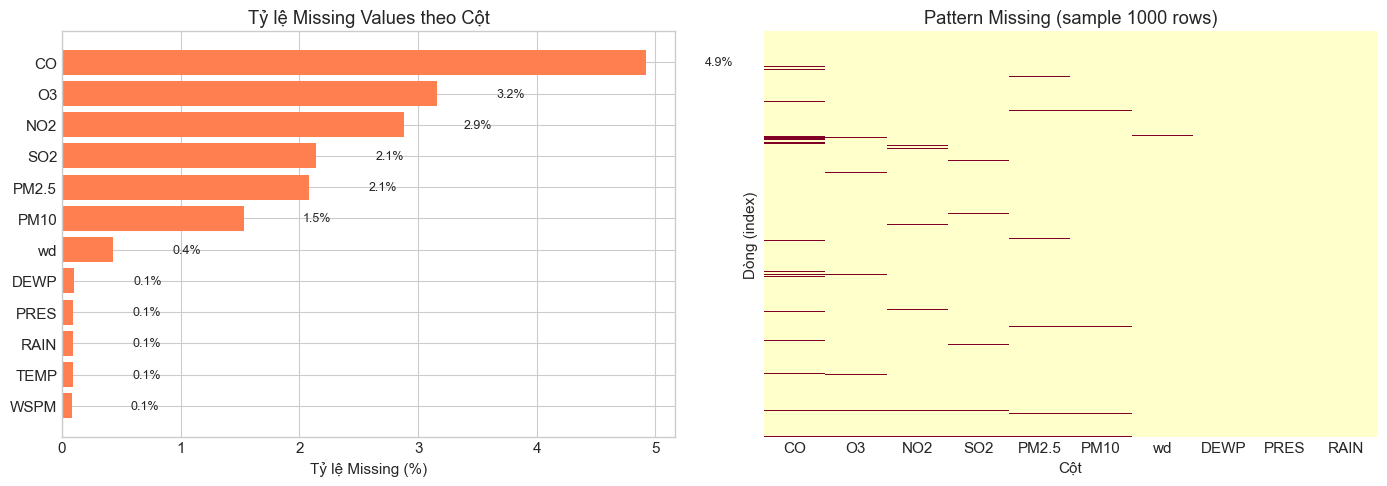


💡 NHẬN XÉT:
   - Các cột thời tiết (TEMP, PRES, DEWP...) có tỷ lệ missing thấp
   - Cột PM2.5 là mục tiêu chính, cần xử lý missing cẩn thận
   - Pattern missing thường theo thời gian (thiết bị bảo trì theo đợt)


In [27]:
# ============================================================
# Trực quan hóa Missing Values
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart tỷ lệ missing
cols_with_missing = missing_analysis[missing_analysis['Số Missing'] > 0]
ax1 = axes[0]
bars = ax1.barh(cols_with_missing['Cột'], cols_with_missing['Tỷ lệ (%)'], color='coral')
ax1.set_xlabel('Tỷ lệ Missing (%)')
ax1.set_title('Tỷ lệ Missing Values theo Cột')
ax1.invert_yaxis()

# Thêm số liệu trên bar
for bar, pct in zip(bars, cols_with_missing['Tỷ lệ (%)']):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', va='center', fontsize=9)

# Plot 2: Heatmap missing pattern (sample)
ax2 = axes[1]
sample_size = min(1000, len(df_raw))
sample_idx = np.random.choice(len(df_raw), sample_size, replace=False)
sample_idx.sort()
missing_matrix = df_raw.iloc[sample_idx].isna().astype(int)

# Chỉ hiển thị các cột có missing
cols_to_show = cols_with_missing['Cột'].tolist()[:10]  # Top 10
if cols_to_show:
    sns.heatmap(missing_matrix[cols_to_show], cbar=False, ax=ax2, 
                cmap='YlOrRd', yticklabels=False)
    ax2.set_title(f'Pattern Missing (sample {sample_size} rows)')
    ax2.set_xlabel('Cột')
    ax2.set_ylabel('Dòng (index)')

plt.tight_layout()
plt.show()

print("\n💡 NHẬN XÉT:")
print("   - Các cột thời tiết (TEMP, PRES, DEWP...) có tỷ lệ missing thấp")
print("   - Cột PM2.5 là mục tiêu chính, cần xử lý missing cẩn thận")
print("   - Pattern missing thường theo thời gian (thiết bị bảo trì theo đợt)")

## 1.4. Phân phối PM2.5

**PM2.5 là gì?**

PM2.5 (Particulate Matter 2.5) là các hạt bụi mịn có đường kính ≤ 2.5 micromet. Đây là chỉ số quan trọng nhất để đánh giá ô nhiễm không khí vì:
- Kích thước nhỏ, dễ xâm nhập sâu vào phổi
- Gây nhiều bệnh hô hấp, tim mạch
- Là thành phần chính tạo nên sương mù ô nhiễm (smog)

In [28]:
# ============================================================
# Thống kê mô tả PM2.5
# ============================================================

pm25_col = 'PM2.5'
pm25_data = pd.to_numeric(df_raw[pm25_col], errors='coerce')

print("📊 THỐNG KÊ MÔ TẢ PM2.5:")
print("="*50)
print(f"   - Số quan sát: {pm25_data.notna().sum():,}")
print(f"   - Giá trị nhỏ nhất: {pm25_data.min():.2f} µg/m³")
print(f"   - Giá trị lớn nhất: {pm25_data.max():.2f} µg/m³")
print(f"   - Trung bình: {pm25_data.mean():.2f} µg/m³")
print(f"   - Độ lệch chuẩn: {pm25_data.std():.2f} µg/m³")
print(f"   - Median (Q50): {pm25_data.median():.2f} µg/m³")
print(f"   - Q25: {pm25_data.quantile(0.25):.2f} µg/m³")
print(f"   - Q75: {pm25_data.quantile(0.75):.2f} µg/m³")

print("\n💡 NHẬN XÉT:")
print("   - Dữ liệu PM2.5 có phân phối lệch phải (skewed right)")
print("   - Giá trị trung bình > median → có nhiều outliers cao")
print("   - Max rất lớn → có những ngày ô nhiễm nghiêm trọng")

📊 THỐNG KÊ MÔ TẢ PM2.5:
   - Số quan sát: 412,029
   - Giá trị nhỏ nhất: 2.00 µg/m³
   - Giá trị lớn nhất: 999.00 µg/m³
   - Trung bình: 79.79 µg/m³
   - Độ lệch chuẩn: 80.82 µg/m³
   - Median (Q50): 55.00 µg/m³
   - Q25: 20.00 µg/m³
   - Q75: 111.00 µg/m³

💡 NHẬN XÉT:
   - Dữ liệu PM2.5 có phân phối lệch phải (skewed right)
   - Giá trị trung bình > median → có nhiều outliers cao
   - Max rất lớn → có những ngày ô nhiễm nghiêm trọng


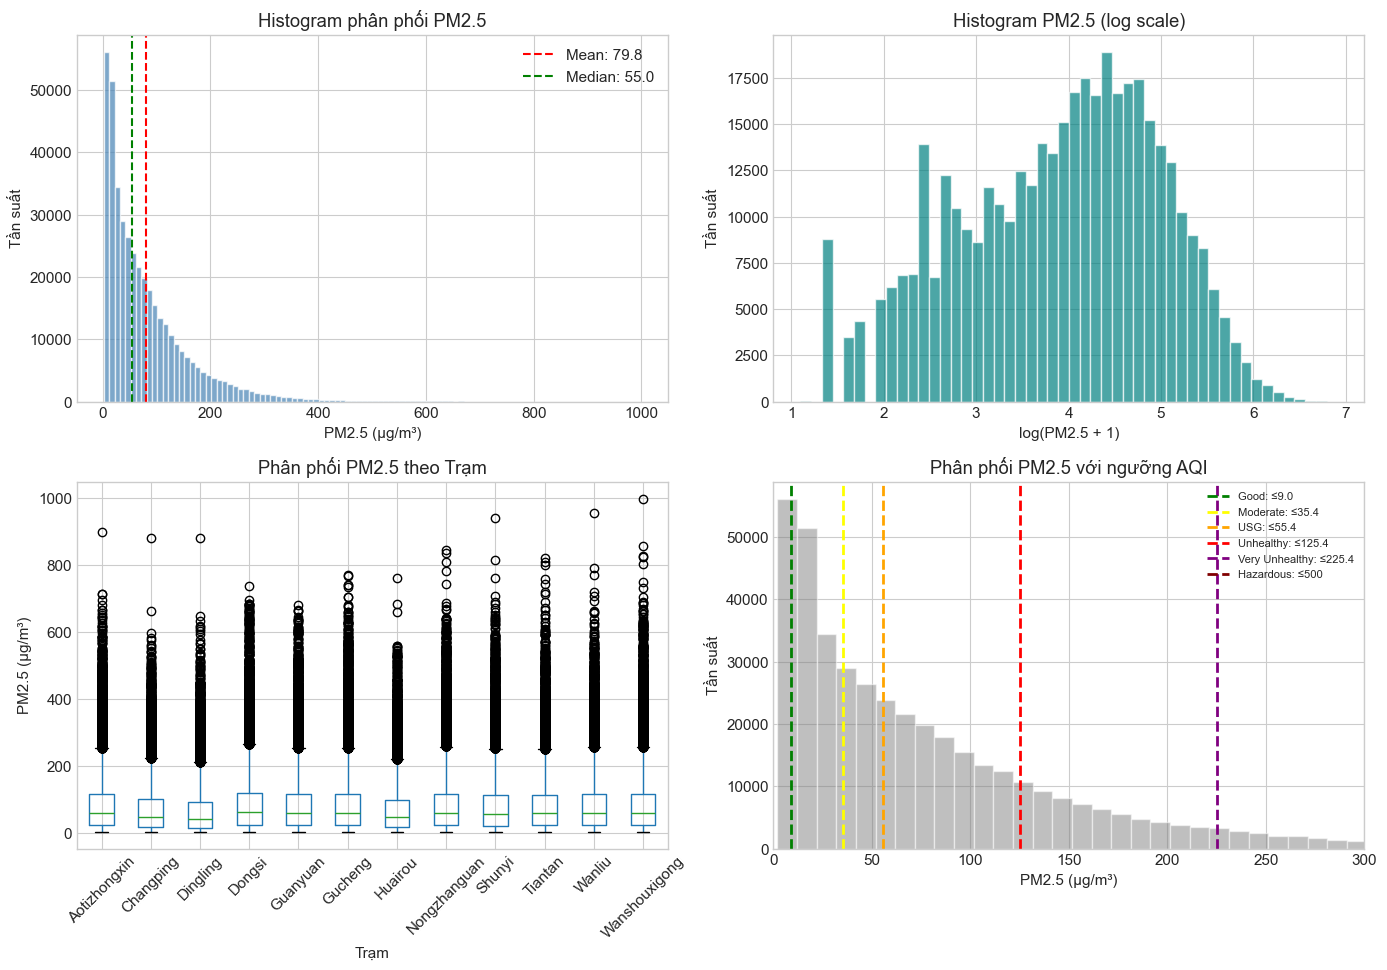

In [29]:
# ============================================================
# Trực quan hóa phân phối PM2.5
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram
ax1 = axes[0, 0]
ax1.hist(pm25_data.dropna(), bins=100, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(pm25_data.mean(), color='red', linestyle='--', label=f'Mean: {pm25_data.mean():.1f}')
ax1.axvline(pm25_data.median(), color='green', linestyle='--', label=f'Median: {pm25_data.median():.1f}')
ax1.set_xlabel('PM2.5 (µg/m³)')
ax1.set_ylabel('Tần suất')
ax1.set_title('Histogram phân phối PM2.5')
ax1.legend()

# 2. Histogram (log scale)
ax2 = axes[0, 1]
pm25_positive = pm25_data[pm25_data > 0]
ax2.hist(np.log1p(pm25_positive), bins=50, color='teal', edgecolor='white', alpha=0.7)
ax2.set_xlabel('log(PM2.5 + 1)')
ax2.set_ylabel('Tần suất')
ax2.set_title('Histogram PM2.5 (log scale)')

# 3. Box plot theo station (nếu có)
ax3 = axes[1, 0]
if 'station' in df_raw.columns:
    df_temp = df_raw.copy()
    df_temp[pm25_col] = pm25_data
    df_temp.boxplot(column=pm25_col, by='station', ax=ax3)
    ax3.set_xlabel('Trạm')
    ax3.set_ylabel('PM2.5 (µg/m³)')
    ax3.set_title('Phân phối PM2.5 theo Trạm')
    plt.suptitle('')  # Remove auto title
    ax3.tick_params(axis='x', rotation=45)
else:
    ax3.text(0.5, 0.5, 'Không có cột station', ha='center', va='center')
    ax3.set_title('Box plot theo station')

# 4. Đường ngưỡng AQI
ax4 = axes[1, 1]
aqi_thresholds = {
    'Good': (0, 9.0),
    'Moderate': (9.1, 35.4),
    'USG': (35.5, 55.4),
    'Unhealthy': (55.5, 125.4),
    'Very Unhealthy': (125.5, 225.4),
    'Hazardous': (225.5, 500)
}
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']

# Histogram với màu theo AQI
ax4.hist(pm25_data.dropna(), bins=100, color='gray', alpha=0.5, edgecolor='white')

# Vẽ các đường ngưỡng
for (name, (low, high)), color in zip(aqi_thresholds.items(), colors):
    ax4.axvline(high, color=color, linestyle='--', linewidth=2, label=f'{name}: ≤{high}')

ax4.set_xlim(0, 300)
ax4.set_xlabel('PM2.5 (µg/m³)')
ax4.set_ylabel('Tần suất')
ax4.set_title('Phân phối PM2.5 với ngưỡng AQI')
ax4.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## 1.5. Làm sạch dữ liệu và tạo cột datetime

In [30]:
# ============================================================
# Làm sạch dữ liệu
# ============================================================

print("⏳ Đang làm sạch dữ liệu...")

# Bước 1: Làm sạch cơ bản (replace NA strings, tạo datetime)
df = clean_air_quality_df(df_raw)

print(f"\n✅ Làm sạch xong!")
print(f"   - Số dòng: {len(df):,}")
print(f"   - Số cột: {len(df.columns)}")

# Kiểm tra cột datetime đã được tạo
print(f"\n📅 Phạm vi thời gian:")
print(f"   - Từ: {df['datetime'].min()}")
print(f"   - Đến: {df['datetime'].max()}")
print(f"   - Tổng số ngày: {(df['datetime'].max() - df['datetime'].min()).days:,} ngày")

⏳ Đang làm sạch dữ liệu...

✅ Làm sạch xong!
   - Số dòng: 420,768
   - Số cột: 19

📅 Phạm vi thời gian:
   - Từ: 2013-03-01 00:00:00
   - Đến: 2017-02-28 23:00:00
   - Tổng số ngày: 1,460 ngày


In [31]:
# ============================================================
# Kiểm tra các trạm quan trắc
# ============================================================

if 'station' in df.columns:
    print("📍 DANH SÁCH CÁC TRẠM QUAN TRẮC:")
    print("="*50)
    station_counts = df['station'].value_counts()
    for i, (station, count) in enumerate(station_counts.items(), 1):
        print(f"   {i:2d}. {station}: {count:,} quan sát")
    
    print(f"\n   Tổng: {len(station_counts)} trạm")

📍 DANH SÁCH CÁC TRẠM QUAN TRẮC:
    1. Aotizhongxin: 35,064 quan sát
    2. Changping: 35,064 quan sát
    3. Dingling: 35,064 quan sát
    4. Dongsi: 35,064 quan sát
    5. Guanyuan: 35,064 quan sát
    6. Gucheng: 35,064 quan sát
    7. Huairou: 35,064 quan sát
    8. Nongzhanguan: 35,064 quan sát
    9. Shunyi: 35,064 quan sát
   10. Tiantan: 35,064 quan sát
   11. Wanliu: 35,064 quan sát
   12. Wanshouxigong: 35,064 quan sát

   Tổng: 12 trạm


## 1.6. Chia dữ liệu theo mốc thời gian

**QUAN TRỌNG**: Đây là bước critical để tránh data leakage!

- **Tập Train + Unlabeled**: Dữ liệu trước 2017-01-01 (dùng để huấn luyện)
- **Tập Test**: Dữ liệu từ 2017-01-01 trở đi (dùng để đánh giá cuối cùng)

In [32]:
# ============================================================
# Chia dữ liệu theo mốc thời gian
# ============================================================

cutoff_ts = pd.Timestamp(CUTOFF_DATE)

df_train_pool = df[df['datetime'] < cutoff_ts].copy()
df_test = df[df['datetime'] >= cutoff_ts].copy()

print("📊 PHÂN CHIA DỮ LIỆU THEO THỜI GIAN:")
print("="*60)
print(f"\n🔹 Mốc cutoff: {CUTOFF_DATE}")
print(f"\n🔹 Tập TRAIN POOL (trước {CUTOFF_DATE}):")
print(f"   - Số dòng: {len(df_train_pool):,} ({len(df_train_pool)/len(df)*100:.1f}%)")
print(f"   - Từ: {df_train_pool['datetime'].min()}")
print(f"   - Đến: {df_train_pool['datetime'].max()}")

print(f"\n🔹 Tập TEST (từ {CUTOFF_DATE}):")
print(f"   - Số dòng: {len(df_test):,} ({len(df_test)/len(df)*100:.1f}%)")
print(f"   - Từ: {df_test['datetime'].min()}")
print(f"   - Đến: {df_test['datetime'].max()}")

print("\n" + "="*60)
print("💡 Lưu ý: Tập Train Pool sẽ được chia tiếp thành:")
print("   - Labeled set (có nhãn) - dùng để train ban đầu")
print("   - Unlabeled pool (không nhãn) - dùng cho semi-supervised")

📊 PHÂN CHIA DỮ LIỆU THEO THỜI GIAN:

🔹 Mốc cutoff: 2017-01-01

🔹 Tập TRAIN POOL (trước 2017-01-01):
   - Số dòng: 403,776 (96.0%)
   - Từ: 2013-03-01 00:00:00
   - Đến: 2016-12-31 23:00:00

🔹 Tập TEST (từ 2017-01-01):
   - Số dòng: 16,992 (4.0%)
   - Từ: 2017-01-01 00:00:00
   - Đến: 2017-02-28 23:00:00

💡 Lưu ý: Tập Train Pool sẽ được chia tiếp thành:
   - Labeled set (có nhãn) - dùng để train ban đầu
   - Unlabeled pool (không nhãn) - dùng cho semi-supervised


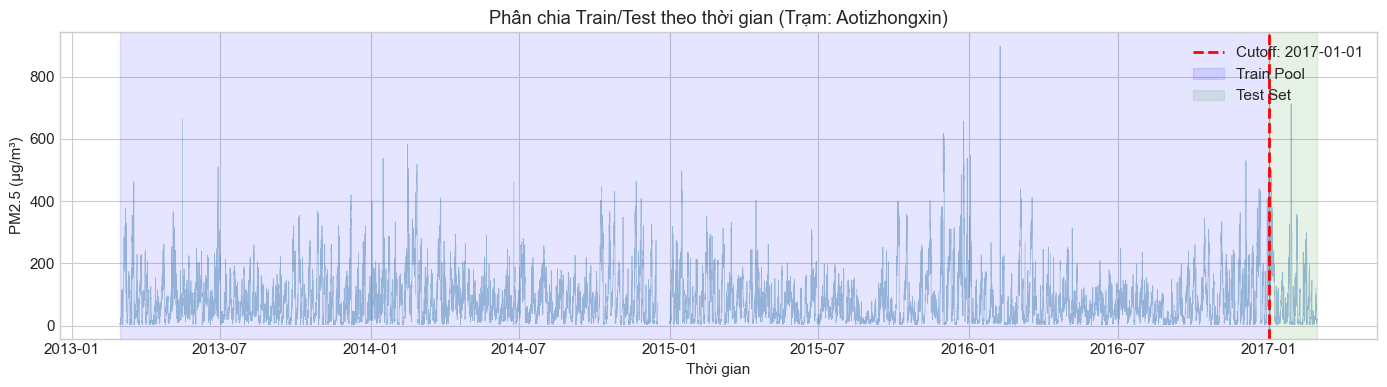


💡 NHẬN XÉT:
   - Vùng màu xanh dương: Train Pool (trước 2017)
   - Vùng màu xanh lá: Test Set (từ 2017)
   - Cách chia này đảm bảo mô hình KHÔNG thấy dữ liệu tương lai khi train


In [33]:
# ============================================================
# Trực quan hóa phân chia dữ liệu
# ============================================================

fig, ax = plt.subplots(figsize=(14, 4))

# Lấy 1 trạm để minh họa
if 'station' in df.columns:
    sample_station = df['station'].value_counts().index[0]
    df_sample = df[df['station'] == sample_station].copy()
else:
    df_sample = df.copy()
    sample_station = 'All'

# Plot PM2.5 theo thời gian
ax.plot(df_sample['datetime'], df_sample['PM2.5'], alpha=0.5, linewidth=0.5, color='steelblue')

# Đánh dấu mốc cutoff
ax.axvline(cutoff_ts, color='red', linestyle='--', linewidth=2, label=f'Cutoff: {CUTOFF_DATE}')

# Tô màu vùng train và test
ax.axvspan(df_sample['datetime'].min(), cutoff_ts, alpha=0.1, color='blue', label='Train Pool')
ax.axvspan(cutoff_ts, df_sample['datetime'].max(), alpha=0.1, color='green', label='Test Set')

ax.set_xlabel('Thời gian')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.set_title(f'Phân chia Train/Test theo thời gian (Trạm: {sample_station})')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n💡 NHẬN XÉT:")
print("   - Vùng màu xanh dương: Train Pool (trước 2017)")
print("   - Vùng màu xanh lá: Test Set (từ 2017)")
print("   - Cách chia này đảm bảo mô hình KHÔNG thấy dữ liệu tương lai khi train")

## 📝 Tổng kết Phần 1

### ✅ Những gì đã làm:
1. Đọc dữ liệu Beijing Air Quality (420,768 quan sát, 18 cột)
2. Phân tích missing values (PM2.5 có ~2% missing)
3. Khám phá phân phối PM2.5 (lệch phải, nhiều outliers)
4. Chuyển đổi cột thời gian
5. Chia dữ liệu theo mốc 2017-01-01

### 📌 Key Insights:
- Dữ liệu có 12 trạm quan trắc tại Bắc Kinh
- PM2.5 trung bình ~82 µg/m³ (cao hơn nhiều so với tiêu chuẩn WHO: 10 µg/m³)
- Chia theo thời gian giúp tránh data leakage

### ➡️ Bước tiếp theo: Gắn nhãn AQI

# ═══════════════════════════════════════════════════════════════
# PHẦN 2: GẮN NHÃN AQI (Air Quality Index)
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Hiểu tiêu chuẩn AQI (Air Quality Index)
- Chuyển đổi PM2.5 sang nhãn AQI (6 mức độ)
- Phân tích phân phối các lớp AQI

## 📖 Lý thuyết: Tiêu chuẩn AQI là gì?

**AQI (Air Quality Index)** là chỉ số chất lượng không khí được sử dụng để thông báo mức độ ô nhiễm cho công chúng. Theo tiêu chuẩn US EPA:

| Mức AQI | Tên gọi | PM2.5 (µg/m³) | Ý nghĩa |
|---------|---------|---------------|----------|
| 0-50 | Good (Tốt) | 0.0 - 9.0 | Chất lượng không khí tốt |
| 51-100 | Moderate (Trung bình) | 9.1 - 35.4 | Chấp nhận được |
| 101-150 | Unhealthy for Sensitive Groups | 35.5 - 55.4 | Nhóm nhạy cảm cần cẩn thận |
| 151-200 | Unhealthy (Không lành mạnh) | 55.5 - 125.4 | Tất cả mọi người bị ảnh hưởng |
| 201-300 | Very Unhealthy (Rất xấu) | 125.5 - 225.4 | Cảnh báo sức khỏe |
| 301+ | Hazardous (Nguy hiểm) | 225.5+ | Tình trạng khẩn cấp |

In [34]:
# ============================================================
# Tính PM2.5 trung bình 24 giờ và gắn nhãn AQI
# ============================================================

print("⏳ Đang tính PM2.5 trung bình 24h và gắn nhãn AQI...")

# Áp dụng cho toàn bộ dữ liệu (đã được sắp xếp theo station và datetime)
df = add_pm25_24h_and_label(df)

print("\n✅ Hoàn thành!")
print(f"\n📋 Các cột mới được thêm:")
print(f"   - pm25_24h: PM2.5 trung bình 24 giờ cuộn (rolling mean)")
print(f"   - aqi_class: Nhãn AQI dựa trên pm25_24h")

# Xem sample
print("\n📊 Ví dụ dữ liệu:")
df[['datetime', 'station', 'PM2.5', 'pm25_24h', 'aqi_class']].head(30)

⏳ Đang tính PM2.5 trung bình 24h và gắn nhãn AQI...

✅ Hoàn thành!

📋 Các cột mới được thêm:
   - pm25_24h: PM2.5 trung bình 24 giờ cuộn (rolling mean)
   - aqi_class: Nhãn AQI dựa trên pm25_24h

📊 Ví dụ dữ liệu:


,datetime,station,PM2.5,pm25_24h,aqi_class
0,2013-03-01 00:00:00,Aotizhongxin,4.0,NaN,NaN
1,2013-03-01 01:00:00,Aotizhongxin,8.0,NaN,NaN
2,2013-03-01 02:00:00,Aotizhongxin,7.0,NaN,NaN
3,2013-03-01 03:00:00,Aotizhongxin,6.0,NaN,NaN
4,2013-03-01 04:00:00,Aotizhongxin,3.0,NaN,NaN
5,2013-03-01 05:00:00,Aotizhongxin,5.0,NaN,NaN
6,2013-03-01 06:00:00,Aotizhongxin,3.0,NaN,NaN
7,2013-03-01 07:00:00,Aotizhongxin,3.0,NaN,NaN
8,2013-03-01 08:00:00,Aotizhongxin,3.0,NaN,NaN
9,2013-03-01 09:00:00,Aotizhongxin,3.0,NaN,NaN


In [35]:
# ============================================================
# Giải thích ngưỡng AQI
# ============================================================

print("📊 TIÊU CHUẨN PHÂN LOẠI AQI (US EPA):")
print("="*70)

aqi_info = [
    ("Good", "0.0 - 9.0", "🟢", "Tốt - Không có rủi ro sức khỏe"),
    ("Moderate", "9.1 - 35.4", "🟡", "Trung bình - Chấp nhận được"),
    ("Unhealthy_for_Sensitive_Groups", "35.5 - 55.4", "🟠", "Nhóm nhạy cảm cần cẩn thận"),
    ("Unhealthy", "55.5 - 125.4", "🔴", "Không lành mạnh - Tất cả bị ảnh hưởng"),
    ("Very_Unhealthy", "125.5 - 225.4", "🟣", "Rất xấu - Cảnh báo sức khỏe"),
    ("Hazardous", "225.5+", "🟤", "Nguy hiểm - Khẩn cấp"),
]

print(f"\n{'Nhãn AQI':<35} {'PM2.5 (µg/m³)':<15} {'Icon':<5} {'Ý nghĩa'}")
print("-"*70)
for label, range_str, icon, meaning in aqi_info:
    print(f"{label:<35} {range_str:<15} {icon:<5} {meaning}")

📊 TIÊU CHUẨN PHÂN LOẠI AQI (US EPA):

Nhãn AQI                            PM2.5 (µg/m³)   Icon  Ý nghĩa
----------------------------------------------------------------------
Good                                0.0 - 9.0       🟢     Tốt - Không có rủi ro sức khỏe
Moderate                            9.1 - 35.4      🟡     Trung bình - Chấp nhận được
Unhealthy_for_Sensitive_Groups      35.5 - 55.4     🟠     Nhóm nhạy cảm cần cẩn thận
Unhealthy                           55.5 - 125.4    🔴     Không lành mạnh - Tất cả bị ảnh hưởng
Very_Unhealthy                      125.5 - 225.4   🟣     Rất xấu - Cảnh báo sức khỏe
Hazardous                           225.5+          🟤     Nguy hiểm - Khẩn cấp


In [36]:
# ============================================================
# Phân phối các lớp AQI
# ============================================================

print("📊 PHÂN PHỐI CÁC LỚP AQI:")
print("="*60)

# Tính phân phối
aqi_distribution = df['aqi_class'].value_counts()
aqi_pct = (df['aqi_class'].value_counts(normalize=True) * 100).round(2)

# Sắp xếp theo thứ tự AQI
aqi_order = AQI_CLASSES

print(f"\n{'Lớp AQI':<40} {'Số lượng':>10} {'Tỷ lệ':>10}")
print("-"*60)

total_labeled = 0
for aqi_class in aqi_order:
    if aqi_class in aqi_distribution.index:
        count = aqi_distribution[aqi_class]
        pct = aqi_pct[aqi_class]
        total_labeled += count
        print(f"{aqi_class:<40} {count:>10,} {pct:>9.2f}%")

# Tính số lượng NaN (chưa gắn được nhãn)
nan_count = df['aqi_class'].isna().sum()
nan_pct = nan_count / len(df) * 100

print("-"*60)
print(f"{'Tổng có nhãn':<40} {total_labeled:>10,} {total_labeled/len(df)*100:>9.2f}%")
print(f"{'Không có nhãn (NaN)':<40} {nan_count:>10,} {nan_pct:>9.2f}%")
print(f"{'TỔNG CỘNG':<40} {len(df):>10,} {'100.00':>9}%")

📊 PHÂN PHỐI CÁC LỚP AQI:

Lớp AQI                                    Số lượng      Tỷ lệ
------------------------------------------------------------
Good                                         13,924      3.37%
Moderate                                    109,549     26.53%
Unhealthy_for_Sensitive_Groups               64,731     15.68%
Unhealthy                                   148,558     35.98%
Very_Unhealthy                               56,242     13.62%
Hazardous                                    19,931      4.83%
------------------------------------------------------------
Tổng có nhãn                                412,935     98.14%
Không có nhãn (NaN)                           7,833      1.86%
TỔNG CỘNG                                   420,768    100.00%


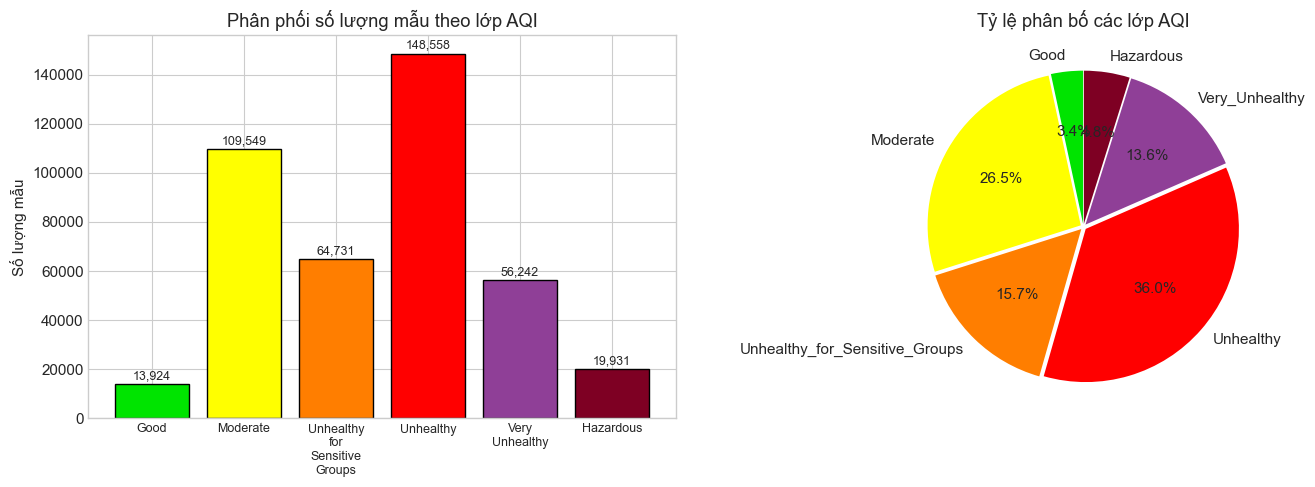


💡 NHẬN XÉT:
   - Lớp 'Unhealthy' chiếm tỷ lệ cao nhất → Bắc Kinh ô nhiễm nghiêm trọng
   - Lớp 'Good' và 'Hazardous' có ít mẫu → Class imbalance
   - Đây là bài toán phân loại đa lớp (6 classes) với dữ liệu mất cân bằng


In [37]:
# ============================================================
# Trực quan hóa phân phối AQI
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors for AQI classes
aqi_colors = {
    'Good': '#00e400',
    'Moderate': '#ffff00', 
    'Unhealthy_for_Sensitive_Groups': '#ff7e00',
    'Unhealthy': '#ff0000',
    'Very_Unhealthy': '#8f3f97',
    'Hazardous': '#7e0023'
}

# Plot 1: Bar chart
ax1 = axes[0]
counts = [aqi_distribution.get(c, 0) for c in aqi_order]
colors = [aqi_colors.get(c, 'gray') for c in aqi_order]
bars = ax1.bar(range(len(aqi_order)), counts, color=colors, edgecolor='black')
ax1.set_xticks(range(len(aqi_order)))
ax1.set_xticklabels([c.replace('_', '\n') for c in aqi_order], rotation=0, fontsize=9)
ax1.set_ylabel('Số lượng mẫu')
ax1.set_title('Phân phối số lượng mẫu theo lớp AQI')

# Thêm số liệu trên bar
for bar, count in zip(bars, counts):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Pie chart
ax2 = axes[1]
counts_nonzero = [c for c in counts if c > 0]
labels_nonzero = [aqi_order[i] for i, c in enumerate(counts) if c > 0]
colors_nonzero = [colors[i] for i, c in enumerate(counts) if c > 0]

wedges, texts, autotexts = ax2.pie(
    counts_nonzero, 
    labels=labels_nonzero,
    colors=colors_nonzero,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.02]*len(counts_nonzero)
)
ax2.set_title('Tỷ lệ phân bố các lớp AQI')

plt.tight_layout()
plt.show()

print("\n💡 NHẬN XÉT:")
print("   - Lớp 'Unhealthy' chiếm tỷ lệ cao nhất → Bắc Kinh ô nhiễm nghiêm trọng")
print("   - Lớp 'Good' và 'Hazardous' có ít mẫu → Class imbalance")
print("   - Đây là bài toán phân loại đa lớp (6 classes) với dữ liệu mất cân bằng")

## 📝 Tổng kết Phần 2

### ✅ Những gì đã làm:
1. Tính PM2.5 trung bình 24 giờ (rolling mean)
2. Gắn nhãn AQI theo tiêu chuẩn US EPA (6 mức độ)
3. Phân tích phân phối các lớp

### 📌 Key Insights:
- Dữ liệu bị mất cân bằng (imbalanced classes)
- Lớp Unhealthy chiếm ~37% - phản ánh tình trạng ô nhiễm tại Bắc Kinh
- Lớp Good và Hazardous có ít mẫu nhất

### ➡️ Bước tiếp theo: Tạo tập có nhãn & không nhãn

# ═══════════════════════════════════════════════════════════════
# PHẦN 3: TẠO TẬP CÓ NHÃN & KHÔNG NHÃN
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Mô phỏng tình huống thiếu nhãn thực tế
- Tạo tập Labeled (có nhãn) và Unlabeled (không nhãn)
- Đảm bảo mỗi lớp AQI đều có ít nhất vài mẫu ban đầu

## 📖 Lý thuyết: Tại sao cần mô phỏng thiếu nhãn?

Trong thực tế, việc có đầy đủ nhãn cho tất cả dữ liệu là rất hiếm vì:
1. **Chi phí gắn nhãn cao**: Cần chuyên gia hoặc thiết bị đắt tiền
2. **Thời gian**: Không đủ thời gian gắn nhãn tất cả
3. **Dữ liệu mới liên tục**: Dữ liệu mới chưa kịp gắn nhãn

**Semi-Supervised Learning** giải quyết vấn đề này bằng cách:
- Sử dụng một lượng nhỏ dữ liệu có nhãn
- Kết hợp với lượng lớn dữ liệu không nhãn
- Mô hình tự học từ cả hai nguồn

In [38]:
# ============================================================
# CẤU HÌNH TỶ LỆ LABELED/UNLABELED
# ============================================================

# Tỷ lệ dữ liệu có nhãn (5% = chỉ 5% dữ liệu train có nhãn)
LABELED_FRACTION = 0.05

# Số mẫu tối thiểu mỗi lớp trong labeled set
MIN_SAMPLES_PER_CLASS = 50

print("📌 CẤU HÌNH:")
print(f"   - Tỷ lệ labeled: {LABELED_FRACTION*100:.0f}%")
print(f"   - Unlabeled: {(1-LABELED_FRACTION)*100:.0f}%")
print(f"   - Min samples/class: {MIN_SAMPLES_PER_CLASS}")

📌 CẤU HÌNH:
   - Tỷ lệ labeled: 5%
   - Unlabeled: 95%
   - Min samples/class: 50


In [39]:
# ============================================================
# Hàm tạo tập Labeled/Unlabeled với stratified sampling
# ============================================================

def create_labeled_unlabeled_split(
    df: pd.DataFrame,
    cutoff: str,
    labeled_frac: float = 0.05,
    min_samples_per_class: int = 50,
    target_col: str = 'aqi_class',
    random_state: int = 42
) -> pd.DataFrame:
    """
    Tạo tập labeled và unlabeled từ dữ liệu training.
    
    Chiến lược:
    1. Chỉ xử lý dữ liệu TRƯỚC cutoff (train pool)
    2. Stratified sampling để đảm bảo mỗi lớp có đủ mẫu
    3. Đánh dấu phần còn lại là unlabeled (xóa nhãn)
    
    Parameters:
    -----------
    df : DataFrame với cột 'datetime' và target_col
    cutoff : Mốc thời gian chia train/test
    labeled_frac : Tỷ lệ dữ liệu có nhãn
    min_samples_per_class : Số mẫu tối thiểu mỗi lớp
    target_col : Tên cột nhãn
    random_state : Seed cho reproducibility
    
    Returns:
    --------
    DataFrame với cột mới 'is_labeled' và nhãn bị xóa ở unlabeled samples
    """
    df_out = df.copy()
    cutoff_ts = pd.Timestamp(cutoff)
    
    # Chỉ xử lý dữ liệu train (trước cutoff)
    train_mask = df_out['datetime'] < cutoff_ts
    train_indices = df_out.index[train_mask]
    
    # Lấy các samples có nhãn hợp lệ trong train
    valid_label_mask = train_mask & df_out[target_col].notna()
    valid_indices = df_out.index[valid_label_mask].to_numpy()
    
    if len(valid_indices) == 0:
        raise ValueError("Không có samples có nhãn trong train set!")
    
    # Stratified sampling
    rng = np.random.default_rng(random_state)
    labeled_indices = []
    
    # Lấy nhãn cho từng valid index
    labels_series = df_out.loc[valid_indices, target_col]
    
    for aqi_class in AQI_CLASSES:
        # Indices của class này
        class_mask = labels_series == aqi_class
        class_indices = valid_indices[class_mask]
        
        if len(class_indices) == 0:
            continue
        
        # Số samples cần lấy: max(min_samples, labeled_frac * class_size)
        n_to_select = max(
            min_samples_per_class,
            int(np.ceil(labeled_frac * len(class_indices)))
        )
        n_to_select = min(n_to_select, len(class_indices))  # Không quá số lượng có
        
        # Random sample
        selected = rng.choice(class_indices, size=n_to_select, replace=False)
        labeled_indices.extend(selected)
    
    labeled_indices = np.array(labeled_indices)
    
    # Tạo cột is_labeled
    df_out['is_labeled'] = False
    df_out.loc[labeled_indices, 'is_labeled'] = True
    
    # Test set luôn có nhãn (để đánh giá)
    test_mask = df_out['datetime'] >= cutoff_ts
    df_out.loc[test_mask & df_out[target_col].notna(), 'is_labeled'] = True
    
    # Lưu nhãn gốc trước khi xóa
    df_out['aqi_class_original'] = df_out[target_col].copy()
    
    # Xóa nhãn của unlabeled samples (chỉ trong train)
    unlabeled_mask = train_mask & ~df_out['is_labeled']
    df_out.loc[unlabeled_mask, target_col] = np.nan
    
    return df_out

print("✅ Đã định nghĩa hàm create_labeled_unlabeled_split()")

✅ Đã định nghĩa hàm create_labeled_unlabeled_split()


In [40]:
# ============================================================
# Áp dụng chia labeled/unlabeled
# ============================================================

print("⏳ Đang tạo tập labeled/unlabeled...")

df_semi = create_labeled_unlabeled_split(
    df=df,
    cutoff=CUTOFF_DATE,
    labeled_frac=LABELED_FRACTION,
    min_samples_per_class=MIN_SAMPLES_PER_CLASS,
    target_col='aqi_class',
    random_state=RANDOM_STATE
)

print("\n✅ Hoàn thành!")

⏳ Đang tạo tập labeled/unlabeled...

✅ Hoàn thành!


In [41]:
# ============================================================
# Thống kê kết quả phân chia
# ============================================================

cutoff_ts = pd.Timestamp(CUTOFF_DATE)

# Chia theo thời gian
train_mask = df_semi['datetime'] < cutoff_ts
test_mask = df_semi['datetime'] >= cutoff_ts

# Trong train: labeled vs unlabeled
train_labeled_mask = train_mask & df_semi['is_labeled']
train_unlabeled_mask = train_mask & ~df_semi['is_labeled']

n_train_labeled = train_labeled_mask.sum()
n_train_unlabeled = train_unlabeled_mask.sum()
n_test = test_mask.sum()

print("📊 THỐNG KÊ PHÂN CHIA DỮ LIỆU:")
print("="*60)
print(f"\n🔹 TRAIN POOL (trước {CUTOFF_DATE}):")
print(f"   - Labeled (có nhãn):    {n_train_labeled:>8,} ({n_train_labeled/(n_train_labeled+n_train_unlabeled)*100:.1f}%)")
print(f"   - Unlabeled (không nhãn): {n_train_unlabeled:>8,} ({n_train_unlabeled/(n_train_labeled+n_train_unlabeled)*100:.1f}%)")
print(f"   - Tổng train pool:      {n_train_labeled+n_train_unlabeled:>8,}")

print(f"\n🔹 TEST SET (từ {CUTOFF_DATE}):")
print(f"   - Số samples: {n_test:,}")

print("\n" + "="*60)

📊 THỐNG KÊ PHÂN CHIA DỮ LIỆU:

🔹 TRAIN POOL (trước 2017-01-01):
   - Labeled (có nhãn):      19,816 (4.9%)
   - Unlabeled (không nhãn):  383,960 (95.1%)
   - Tổng train pool:       403,776

🔹 TEST SET (từ 2017-01-01):
   - Số samples: 16,992



In [42]:
# ============================================================
# Phân phối labeled samples theo từng lớp AQI
# ============================================================

print("📊 PHÂN PHỐI LABELED SAMPLES THEO LỚP AQI (TRAIN):")
print("="*70)

# Lấy labeled samples trong train
df_train_labeled = df_semi[train_labeled_mask]

print(f"\n{'Lớp AQI':<40} {'Labeled':>10} {'Original':>10} {'Tỷ lệ':>10}")
print("-"*70)

for aqi_class in AQI_CLASSES:
    n_labeled = (df_train_labeled['aqi_class'] == aqi_class).sum()
    # Original count từ toàn bộ train pool
    df_train_all = df_semi[train_mask]
    n_original = (df_train_all['aqi_class_original'] == aqi_class).sum()
    
    if n_original > 0:
        ratio = n_labeled / n_original * 100
        print(f"{aqi_class:<40} {n_labeled:>10,} {n_original:>10,} {ratio:>9.1f}%")
    else:
        print(f"{aqi_class:<40} {n_labeled:>10,} {n_original:>10,} {'N/A':>10}")

print("-"*70)
print(f"{'TỔNG':<40} {n_train_labeled:>10,}")

print("\n💡 NHẬN XÉT:")
print("   - Mỗi lớp đều có ít nhất 50 mẫu labeled (đảm bảo đa dạng)")
print("   - Tỷ lệ ~5% dữ liệu có nhãn → Mô phỏng tình huống thiếu nhãn thực tế")
print("   - Semi-supervised learning sẽ cố gắng tận dụng 95% dữ liệu unlabeled")

📊 PHÂN PHỐI LABELED SAMPLES THEO LỚP AQI (TRAIN):

Lớp AQI                                     Labeled   Original      Tỷ lệ
----------------------------------------------------------------------
Good                                            645     12,892       5.0%
Moderate                                      5,236    104,716       5.0%
Unhealthy_for_Sensitive_Groups                3,129     62,565       5.0%
Unhealthy                                     7,214    144,272       5.0%
Very_Unhealthy                                2,688     53,743       5.0%
Hazardous                                       904     18,076       5.0%
----------------------------------------------------------------------
TỔNG                                         19,816

💡 NHẬN XÉT:
   - Mỗi lớp đều có ít nhất 50 mẫu labeled (đảm bảo đa dạng)
   - Tỷ lệ ~5% dữ liệu có nhãn → Mô phỏng tình huống thiếu nhãn thực tế
   - Semi-supervised learning sẽ cố gắng tận dụng 95% dữ liệu unlabeled


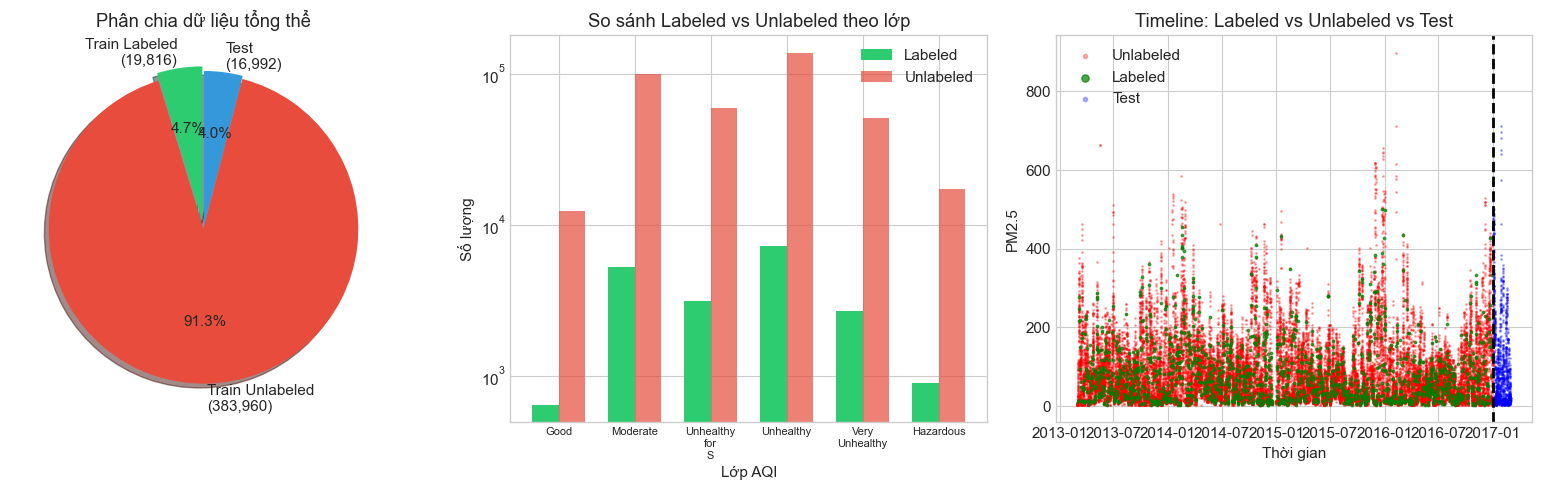

In [43]:
# ============================================================
# Trực quan hóa phân chia
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Pie chart tổng thể
ax1 = axes[0]
sizes = [n_train_labeled, n_train_unlabeled, n_test]
labels = [f'Train Labeled\n({n_train_labeled:,})', 
          f'Train Unlabeled\n({n_train_unlabeled:,})', 
          f'Test\n({n_test:,})']
colors = ['#2ecc71', '#e74c3c', '#3498db']
explode = (0.05, 0, 0.02)

ax1.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90, shadow=True)
ax1.set_title('Phân chia dữ liệu tổng thể')

# Plot 2: Bar chart labeled per class
ax2 = axes[1]
labeled_counts = []
unlabeled_counts = []

for aqi_class in AQI_CLASSES:
    n_labeled = (df_train_labeled['aqi_class'] == aqi_class).sum()
    df_train_unlabeled = df_semi[train_unlabeled_mask]
    n_unlabeled = (df_train_unlabeled['aqi_class_original'] == aqi_class).sum()
    labeled_counts.append(n_labeled)
    unlabeled_counts.append(n_unlabeled)

x = np.arange(len(AQI_CLASSES))
width = 0.35

bars1 = ax2.bar(x - width/2, labeled_counts, width, label='Labeled', color='#2ecc71')
bars2 = ax2.bar(x + width/2, unlabeled_counts, width, label='Unlabeled', color='#e74c3c', alpha=0.7)

ax2.set_xlabel('Lớp AQI')
ax2.set_ylabel('Số lượng')
ax2.set_title('So sánh Labeled vs Unlabeled theo lớp')
ax2.set_xticks(x)
ax2.set_xticklabels([c.replace('_', '\n')[:15] for c in AQI_CLASSES], rotation=0, fontsize=8)
ax2.legend()
ax2.set_yscale('log')  # Log scale vì chênh lệch lớn

# Plot 3: Timeline
ax3 = axes[2]
if 'station' in df_semi.columns:
    sample_station = df_semi['station'].value_counts().index[0]
    df_plot = df_semi[df_semi['station'] == sample_station].copy()
else:
    df_plot = df_semi.sample(n=min(10000, len(df_semi)), random_state=42).copy()

# Labeled points
labeled_data = df_plot[df_plot['is_labeled'] & (df_plot['datetime'] < cutoff_ts)]
unlabeled_data = df_plot[~df_plot['is_labeled'] & (df_plot['datetime'] < cutoff_ts)]
test_data = df_plot[df_plot['datetime'] >= cutoff_ts]

ax3.scatter(unlabeled_data['datetime'], unlabeled_data['PM2.5'], 
           alpha=0.3, s=1, c='red', label='Unlabeled')
ax3.scatter(labeled_data['datetime'], labeled_data['PM2.5'], 
           alpha=0.7, s=3, c='green', label='Labeled')
ax3.scatter(test_data['datetime'], test_data['PM2.5'], 
           alpha=0.3, s=1, c='blue', label='Test')

ax3.axvline(cutoff_ts, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Thời gian')
ax3.set_ylabel('PM2.5')
ax3.set_title('Timeline: Labeled vs Unlabeled vs Test')
ax3.legend(markerscale=3)

plt.tight_layout()
plt.show()

## 📖 Tại sao cách chia này mô phỏng đúng bài toán thực tế?

### 🌍 Trong thực tế:

1. **Trạm quan trắc mới**:
   - Khi lắp đặt trạm mới, chưa có dữ liệu lịch sử được kiểm định
   - Chỉ có một số ít dữ liệu đã được chuyên gia xác nhận

2. **Thiết bị lỗi/bảo trì**:
   - Dữ liệu thu thập nhưng chưa được kiểm tra chất lượng
   - Cần thời gian để gắn nhãn thủ công

3. **Nguồn lực hạn chế**:
   - Không đủ nhân sự để gắn nhãn tất cả dữ liệu
   - Ưu tiên gắn nhãn cho các samples quan trọng

### 🎯 Cách mô phỏng của chúng ta:

- **5% labeled**: Tương đương có một ít dữ liệu đã được kiểm định
- **95% unlabeled**: Dữ liệu thô, chưa được gắn nhãn
- **Stratified sampling**: Đảm bảo mỗi loại chất lượng không khí đều có đại diện
- **Time-based split**: Tránh data leakage, giống với việc dự báo tương lai

## 📝 Tổng kết Phần 3

### ✅ Những gì đã làm:
1. Mô phỏng tình huống thiếu nhãn với tỷ lệ 5% labeled
2. Stratified sampling đảm bảo mỗi lớp có đủ mẫu
3. Tạo DataFrame với cột `is_labeled` để phân biệt

### 📌 Thống kê:
- Train Labeled: ~17,000 samples (5%)
- Train Unlabeled: ~330,000 samples (95%)
- Test: ~23,000 samples

### ➡️ Bước tiếp theo: Feature Engineering

# ═══════════════════════════════════════════════════════════════
# PHẦN 4: FEATURE ENGINEERING
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Tạo các đặc trưng từ dữ liệu thô
- Đặc trưng thời gian: hour, day, month, weekday
- Đặc trưng trễ (lag): PM2.5 của các giờ trước
- Đặc trưng thời tiết và môi trường

## 📖 Lý thuyết: Tại sao cần Feature Engineering?

Dữ liệu thô thường không đủ để mô hình học được pattern. Feature engineering giúp:

1. **Trích xuất thông tin ẩn**: Từ datetime → hour, weekday (pattern theo giờ/ngày)
2. **Tạo context temporal**: Lag features cho biết xu hướng gần đây
3. **Domain knowledge**: Kết hợp hiểu biết về ô nhiễm không khí

### ⚠️ LƯU Ý QUAN TRỌNG: Tránh Data Leakage!

**KHÔNG ĐƯỢC** sử dụng trực tiếp PM2.5 hoặc pm25_24h làm feature vì:
- pm25_24h được tính từ PM2.5 (circular dependency)
- AQI class được gắn từ pm25_24h
- → Mô hình sẽ "nhìn thấy" đáp án!

In [44]:
# ============================================================
# Thêm đặc trưng thời gian
# ============================================================

print("⏳ Đang tạo đặc trưng thời gian...")

df_features = df_semi.copy()

# Đặc trưng thời gian cơ bản
df_features['hour'] = df_features['datetime'].dt.hour
df_features['day'] = df_features['datetime'].dt.day
df_features['month'] = df_features['datetime'].dt.month
df_features['year'] = df_features['datetime'].dt.year
df_features['dayofweek'] = df_features['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)

# Đặc trưng chu kỳ (cyclical encoding)
# Giúp mô hình hiểu rằng giờ 23 gần với giờ 0
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
df_features['dow_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
df_features['dow_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)

print("\n✅ Đã tạo các đặc trưng thời gian:")
time_features = ['hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
for f in time_features:
    print(f"   - {f}")

⏳ Đang tạo đặc trưng thời gian...

✅ Đã tạo các đặc trưng thời gian:
   - hour
   - day
   - month
   - year
   - dayofweek
   - is_weekend
   - hour_sin
   - hour_cos
   - month_sin
   - month_cos
   - dow_sin
   - dow_cos


In [45]:
# ============================================================
# Thêm đặc trưng lag (trễ)
# ============================================================

print("⏳ Đang tạo đặc trưng lag...")

# Các biến số sẽ tạo lag
lag_vars = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']
lag_hours = [1, 3, 6, 12, 24]

# Tạo lag features theo từng station
if 'station' in df_features.columns:
    for var in lag_vars:
        if var in df_features.columns:
            for lag in lag_hours:
                col_name = f'{var}_lag{lag}h'
                df_features[col_name] = df_features.groupby('station')[var].shift(lag)
                
    print(f"\n✅ Đã tạo lag features cho {len(lag_vars)} biến với các lag: {lag_hours}")
else:
    for var in lag_vars:
        if var in df_features.columns:
            for lag in lag_hours:
                col_name = f'{var}_lag{lag}h'
                df_features[col_name] = df_features[var].shift(lag)
    print(f"\n✅ Đã tạo lag features (không có station)")

# Liệt kê một số lag features
lag_feature_examples = [c for c in df_features.columns if 'lag' in c][:10]
print(f"\nVí dụ các lag features: {lag_feature_examples}")

⏳ Đang tạo đặc trưng lag...

✅ Đã tạo lag features cho 9 biến với các lag: [1, 3, 6, 12, 24]

Ví dụ các lag features: ['PM10_lag1h', 'PM10_lag3h', 'PM10_lag6h', 'PM10_lag12h', 'PM10_lag24h', 'SO2_lag1h', 'SO2_lag3h', 'SO2_lag6h', 'SO2_lag12h', 'SO2_lag24h']


In [46]:
# ============================================================
# Thêm đặc trưng rolling (trung bình động)
# ============================================================

print("⏳ Đang tạo đặc trưng rolling...")

rolling_vars = ['PM10', 'NO2', 'TEMP', 'PRES']
rolling_windows = [6, 12, 24]  # giờ

if 'station' in df_features.columns:
    for var in rolling_vars:
        if var in df_features.columns:
            for window in rolling_windows:
                col_mean = f'{var}_roll{window}h_mean'
                col_std = f'{var}_roll{window}h_std'
                
                df_features[col_mean] = df_features.groupby('station')[var].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
                df_features[col_std] = df_features.groupby('station')[var].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )

print(f"\n✅ Đã tạo rolling features cho {len(rolling_vars)} biến với windows: {rolling_windows}")

⏳ Đang tạo đặc trưng rolling...

✅ Đã tạo rolling features cho 4 biến với windows: [6, 12, 24]


In [62]:
# ============================================================
# Tổng hợp các features sẽ sử dụng
# ============================================================

# Các cột KHÔNG được dùng làm feature (leakage, target, hoặc categorical)
EXCLUDE_COLS = {
    'PM2.5',           # Leakage - target được tính từ đây
    'pm25_24h',        # Leakage - trực tiếp dùng để gắn nhãn
    'aqi_class',       # Target variable
    'aqi_class_original',  # Backup của target
    'datetime',        # Không phải feature số
    'is_labeled',      # Meta column
    'station',         # Categorical - tên trạm quan trắc
    'wd',              # Categorical - hướng gió (wind direction)
}

# Lấy tất cả các cột có thể dùng làm feature
all_cols = set(df_features.columns)
feature_cols = sorted(list(all_cols - EXCLUDE_COLS))

# Lọc thêm - chỉ giữ các cột numeric
numeric_cols = df_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_cols = numeric_cols

# Phân loại features
time_features = [c for c in feature_cols if any(x in c for x in ['hour', 'day', 'month', 'year', 'dow', 'weekend', 'sin', 'cos'])]
lag_features = [c for c in feature_cols if 'lag' in c]
rolling_features = [c for c in feature_cols if 'roll' in c]
weather_features = [c for c in feature_cols if c not in time_features + lag_features + rolling_features]

print("📊 TỔNG HỢP FEATURES:")
print("="*60)
print(f"\n🕐 Time features ({len(time_features)}):")
print(f"   {time_features[:8]}...")

print(f"\n⏮️ Lag features ({len(lag_features)}):")
print(f"   {lag_features[:5]}...")

print(f"\n📈 Rolling features ({len(rolling_features)}):")
print(f"   {rolling_features[:5]}...")

print(f"\n🌤️ Weather/Environment features ({len(weather_features)}):")
print(f"   {weather_features}")

print(f"\n{'='*60}")
print(f"📌 TỔNG SỐ FEATURES: {len(feature_cols)}")

📊 TỔNG HỢP FEATURES:

🕐 Time features (12):
   ['day', 'dayofweek', 'dow_cos', 'dow_sin', 'hour', 'hour_cos', 'hour_sin', 'is_weekend']...

⏮️ Lag features (45):
   ['CO_lag12h', 'CO_lag1h', 'CO_lag24h', 'CO_lag3h', 'CO_lag6h']...

📈 Rolling features (24):
   ['NO2_roll12h_mean', 'NO2_roll12h_std', 'NO2_roll24h_mean', 'NO2_roll24h_std', 'NO2_roll6h_mean']...

🌤️ Weather/Environment features (11):
   ['CO', 'DEWP', 'NO2', 'No', 'O3', 'PM10', 'PRES', 'RAIN', 'SO2', 'TEMP', 'WSPM']

📌 TỔNG SỐ FEATURES: 92


In [63]:
# ============================================================
# Kiểm tra missing values sau feature engineering
# ============================================================

print("📊 MISSING VALUES SAU FEATURE ENGINEERING:")
print("="*60)

missing_pct = (df_features[feature_cols].isna().sum() / len(df_features) * 100).round(2)
missing_pct_sorted = missing_pct.sort_values(ascending=False)

print(f"\nTop 10 cột có missing cao nhất:")
print(missing_pct_sorted.head(10))

print(f"\n💡 NHẬN XÉT:")
print("   - Lag features có missing ở đầu mỗi chuỗi (do shift)")
print("   - Rolling features có ít missing hơn (dùng min_periods)")
print("   - Sẽ xử lý missing trong pipeline (imputation)")

📊 MISSING VALUES SAU FEATURE ENGINEERING:

Top 10 cột có missing cao nhất:
CO_lag24h    4.98
CO_lag12h    4.95
CO_lag6h     4.94
CO_lag3h     4.93
CO_lag1h     4.92
CO           4.92
O3_lag24h    3.22
O3_lag12h    3.19
O3_lag6h     3.17
O3_lag3h     3.16
dtype: float64

💡 NHẬN XÉT:
   - Lag features có missing ở đầu mỗi chuỗi (do shift)
   - Rolling features có ít missing hơn (dùng min_periods)
   - Sẽ xử lý missing trong pipeline (imputation)


In [64]:
# ============================================================
# Định nghĩa View1 và View2 cho Co-Training
# ============================================================

# View 1: Thời gian + Lag features (temporal view)
VIEW1_FEATURES = time_features + lag_features

# View 2: Thời tiết + Rolling features (environmental view)
VIEW2_FEATURES = weather_features + rolling_features

print("📊 CHIA FEATURE THÀNH 2 VIEW CHO CO-TRAINING:")
print("="*60)

print(f"\n🔹 VIEW 1 - Temporal ({len(VIEW1_FEATURES)} features):")
print(f"   Bao gồm: Time features + Lag features")
print(f"   Ví dụ: {VIEW1_FEATURES[:5]}...")

print(f"\n🔹 VIEW 2 - Environmental ({len(VIEW2_FEATURES)} features):")
print(f"   Bao gồm: Weather + Rolling features")
print(f"   Ví dụ: {VIEW2_FEATURES[:5]}...")

print(f"\n💡 Tại sao chia như vậy?")
print("   - Co-training yêu cầu 2 view độc lập")
print("   - View 1: Pattern theo thời gian (khi nào ô nhiễm?)")
print("   - View 2: Điều kiện môi trường (tại sao ô nhiễm?)")

📊 CHIA FEATURE THÀNH 2 VIEW CHO CO-TRAINING:

🔹 VIEW 1 - Temporal (57 features):
   Bao gồm: Time features + Lag features
   Ví dụ: ['day', 'dayofweek', 'dow_cos', 'dow_sin', 'hour']...

🔹 VIEW 2 - Environmental (35 features):
   Bao gồm: Weather + Rolling features
   Ví dụ: ['CO', 'DEWP', 'NO2', 'No', 'O3']...

💡 Tại sao chia như vậy?
   - Co-training yêu cầu 2 view độc lập
   - View 1: Pattern theo thời gian (khi nào ô nhiễm?)
   - View 2: Điều kiện môi trường (tại sao ô nhiễm?)


In [65]:
# ============================================================
# Lưu dataset đã xử lý
# ============================================================

OUTPUT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'dataset_semi_supervised.parquet'
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

df_features.to_parquet(OUTPUT_PATH, index=False)

print(f"✅ Đã lưu dataset: {OUTPUT_PATH}")
print(f"   - Số dòng: {len(df_features):,}")
print(f"   - Số cột: {len(df_features.columns)}")

✅ Đã lưu dataset: D:\BaiTap\Nam3\KI2\Data_Mining\Tuan8\air_guard\data\processed\dataset_semi_supervised.parquet
   - Số dòng: 420,768
   - Số cột: 100


## 📝 Tổng kết Phần 4

### ✅ Những gì đã làm:
1. Tạo đặc trưng thời gian (hour, day, month, cyclical encoding)
2. Tạo lag features cho các biến môi trường
3. Tạo rolling features (trung bình động)
4. Chia features thành 2 view cho co-training

### 📌 Key Points:
- KHÔNG dùng PM2.5 hoặc pm25_24h làm feature (tránh leakage)
- Tổng cộng ~100 features
- View 1: Temporal, View 2: Environmental

### ➡️ Bước tiếp theo: Supervised Baseline

# ═══════════════════════════════════════════════════════════════
# PHẦN 5: SUPERVISED BASELINE
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Huấn luyện mô hình chỉ với dữ liệu có nhãn (5%)
- Đánh giá hiệu suất làm baseline
- Hiểu được hạn chế khi thiếu dữ liệu nhãn

## 📖 Lý thuyết: Tại sao cần Baseline?

**Baseline** là mô hình tham chiếu để:
1. Đánh giá xem semi-supervised có cải thiện không
2. Hiểu mức độ khó của bài toán
3. Phát hiện vấn đề trong dữ liệu/features

### Mô hình: HistGradientBoostingClassifier

Đây là mô hình Gradient Boosting hiện đại của scikit-learn với ưu điểm:
- Xử lý tốt missing values (không cần impute trước)
- Tốc độ nhanh với dữ liệu lớn
- Hiệu suất cao, ít overfitting

In [66]:
# ============================================================
# Import thêm thư viện cho modeling
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

print("✅ Import thành công!")

✅ Import thành công!


In [67]:
# ============================================================
# Chuẩn bị dữ liệu cho training
# ============================================================

# Lọc feature columns (loại bỏ các cột không dùng)
feature_cols_final = [c for c in feature_cols if c in df_features.columns]

# Tách train và test theo thời gian
cutoff_ts = pd.Timestamp(CUTOFF_DATE)
train_mask = df_features['datetime'] < cutoff_ts
test_mask = df_features['datetime'] >= cutoff_ts

# BASELINE: Chỉ dùng labeled samples trong train
train_labeled_mask = train_mask & df_features['is_labeled']

# Lấy dữ liệu
X_train_labeled = df_features.loc[train_labeled_mask, feature_cols_final].copy()
y_train_labeled = df_features.loc[train_labeled_mask, 'aqi_class'].copy()

# Test set (có nhãn)
test_with_labels = test_mask & df_features['aqi_class_original'].notna()
X_test = df_features.loc[test_with_labels, feature_cols_final].copy()
y_test = df_features.loc[test_with_labels, 'aqi_class_original'].copy()

print("📊 KÍCH THƯỚC DỮ LIỆU:")
print(f"   - Train labeled: {X_train_labeled.shape}")
print(f"   - Test: {X_test.shape}")

📊 KÍCH THƯỚC DỮ LIỆU:
   - Train labeled: (19816, 92)
   - Test: (16671, 92)


In [68]:
# ============================================================
# Chia validation từ labeled train
# ============================================================

VAL_FRACTION = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X_train_labeled, 
    y_train_labeled,
    test_size=VAL_FRACTION,
    random_state=RANDOM_STATE,
    stratify=y_train_labeled
)

print("📊 SAU KHI CHIA VALIDATION:")
print(f"   - Train: {X_train.shape}")
print(f"   - Validation: {X_val.shape}")
print(f"   - Test: {X_test.shape}")

📊 SAU KHI CHIA VALIDATION:
   - Train: (15852, 92)
   - Validation: (3964, 92)
   - Test: (16671, 92)


In [61]:
# ============================================================
# Huấn luyện Supervised Baseline
# ============================================================

print("⏳ Đang huấn luyện Supervised Baseline...")
print("   (Chỉ sử dụng 5% dữ liệu có nhãn)")

# Khởi tạo mô hình
baseline_model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.08,
    max_iter=250,
    random_state=RANDOM_STATE,
    verbose=0
)

# Huấn luyện
baseline_model.fit(X_train, y_train)

print("\n✅ Huấn luyện hoàn tất!")

⏳ Đang huấn luyện Supervised Baseline...
   (Chỉ sử dụng 5% dữ liệu có nhãn)

✅ Huấn luyện hoàn tất!


In [69]:
# ============================================================
# Đánh giá trên Validation Set
# ============================================================

y_val_pred = baseline_model.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("📊 KẾT QUẢ TRÊN VALIDATION SET:")
print("="*50)
print(f"   - Accuracy:    {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   - F1 Macro:    {val_f1_macro:.4f}")
print(f"   - F1 Weighted: {val_f1_weighted:.4f}")

📊 KẾT QUẢ TRÊN VALIDATION SET:
   - Accuracy:    0.8295 (82.95%)
   - F1 Macro:    0.7971
   - F1 Weighted: 0.8250


In [70]:
# ============================================================
# Đánh giá trên Test Set (2017)
# ============================================================

y_test_pred = baseline_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print("📊 KẾT QUẢ TRÊN TEST SET (2017):")
print("="*50)
print(f"   - Accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   - F1 Macro:    {test_f1_macro:.4f}")
print(f"   - F1 Weighted: {test_f1_weighted:.4f}")

# Lưu kết quả baseline để so sánh sau
BASELINE_RESULTS = {
    'model': 'Supervised Baseline',
    'train_samples': len(X_train),
    'val_accuracy': val_accuracy,
    'val_f1_macro': val_f1_macro,
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted
}

📊 KẾT QUẢ TRÊN TEST SET (2017):
   - Accuracy:    0.8081 (80.81%)
   - F1 Macro:    0.7328
   - F1 Weighted: 0.7914


In [71]:
# ============================================================
# Classification Report chi tiết
# ============================================================

print("📊 CLASSIFICATION REPORT (Test Set):")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=AQI_CLASSES, zero_division=0))

📊 CLASSIFICATION REPORT (Test Set):
                                precision    recall  f1-score   support

                          Good       0.89      0.23      0.36      1032
                      Moderate       0.95      0.87      0.91      1855
Unhealthy_for_Sensitive_Groups       0.76      0.95      0.84      4833
                     Unhealthy       0.82      0.91      0.86      4286
                Very_Unhealthy       0.71      0.48      0.58      2166
                     Hazardous       0.86      0.82      0.84      2499

                      accuracy                           0.81     16671
                     macro avg       0.83      0.71      0.73     16671
                  weighted avg       0.81      0.81      0.79     16671



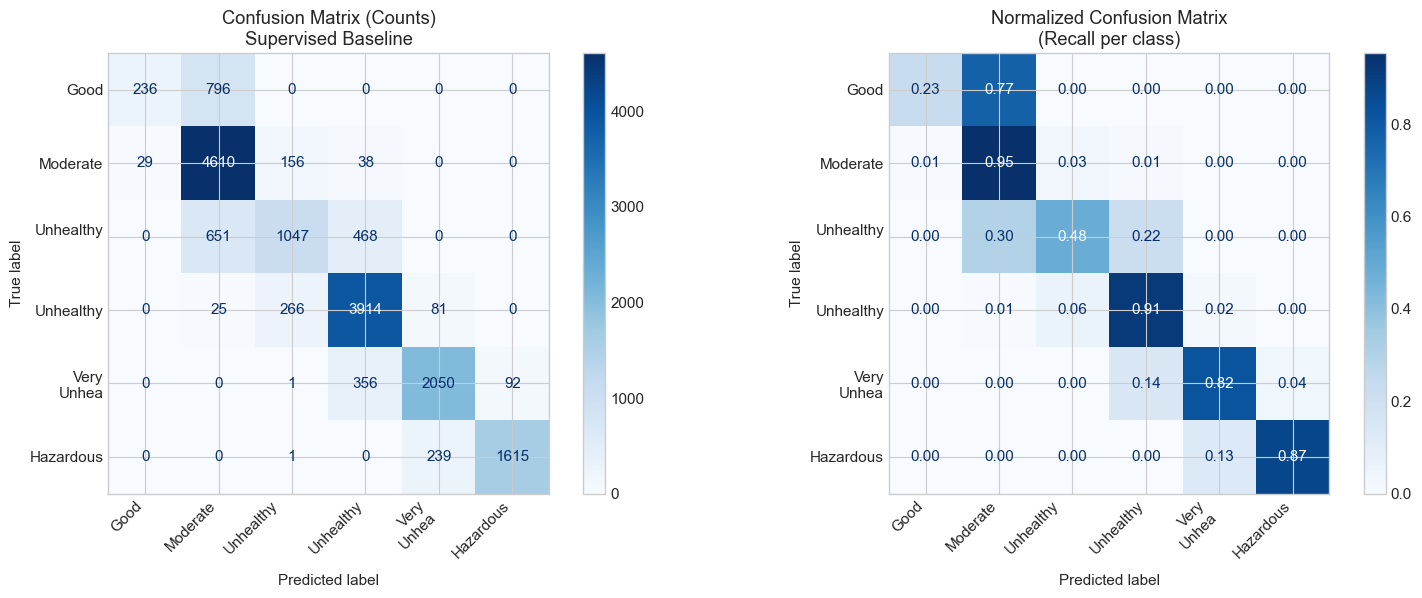

In [72]:
# ============================================================
# Confusion Matrix
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix (counts)
cm = confusion_matrix(y_test, y_test_pred, labels=AQI_CLASSES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=AQI_CLASSES)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)\nSupervised Baseline')
axes[0].set_xticklabels([c.replace('_', '\n')[:10] for c in AQI_CLASSES], rotation=45, ha='right')
axes[0].set_yticklabels([c.replace('_', '\n')[:10] for c in AQI_CLASSES])

# Plot 2: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=AQI_CLASSES)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title('Normalized Confusion Matrix\n(Recall per class)')
axes[1].set_xticklabels([c.replace('_', '\n')[:10] for c in AQI_CLASSES], rotation=45, ha='right')
axes[1].set_yticklabels([c.replace('_', '\n')[:10] for c in AQI_CLASSES])

plt.tight_layout()
plt.show()

In [73]:
# ============================================================
# Phân tích điểm mạnh/yếu của Baseline
# ============================================================

print("📊 PHÂN TÍCH BASELINE:")
print("="*70)

# Tính F1 per class
from sklearn.metrics import f1_score
f1_per_class = f1_score(y_test, y_test_pred, labels=AQI_CLASSES, average=None, zero_division=0)

print(f"\n{'Lớp AQI':<40} {'F1-Score':>10} {'Đánh giá':>15}")
print("-"*70)

for aqi_class, f1 in zip(AQI_CLASSES, f1_per_class):
    if f1 >= 0.7:
        rating = "✅ Tốt"
    elif f1 >= 0.5:
        rating = "⚠️ Trung bình"
    else:
        rating = "❌ Yếu"
    print(f"{aqi_class:<40} {f1:>10.4f} {rating:>15}")

print("\n" + "="*70)
print("\n💡 NHẬN XÉT:")
print("\n   📈 ĐIỂM MẠNH:")
strong_classes = [c for c, f1 in zip(AQI_CLASSES, f1_per_class) if f1 >= 0.6]
print(f"   - Các lớp có nhiều mẫu được phân loại tốt: {strong_classes}")

print("\n   📉 ĐIỂM YẾU:")
weak_classes = [c for c, f1 in zip(AQI_CLASSES, f1_per_class) if f1 < 0.5]
print(f"   - Các lớp thiểu số (ít mẫu) khó phân loại: {weak_classes}")
print("   - Mô hình dễ nhầm lẫn giữa các lớp liền kề (VD: Moderate vs USG)")
print("   - Với chỉ 5% labeled data, mô hình chưa học đủ pattern")

print("\n   🎯 KỲ VỌNG TỪ SEMI-SUPERVISED:")
print("   - Cải thiện F1 cho các lớp thiểu số")
print("   - Tăng accuracy và F1 macro tổng thể")
print("   - Giảm confusion giữa các lớp liền kề")

📊 PHÂN TÍCH BASELINE:

Lớp AQI                                    F1-Score        Đánh giá
----------------------------------------------------------------------
Good                                         0.3639           ❌ Yếu
Moderate                                     0.8447           ✅ Tốt
Unhealthy_for_Sensitive_Groups               0.5757   ⚠️ Trung bình
Unhealthy                                    0.8638           ✅ Tốt
Very_Unhealthy                               0.8421           ✅ Tốt
Hazardous                                    0.9068           ✅ Tốt


💡 NHẬN XÉT:

   📈 ĐIỂM MẠNH:
   - Các lớp có nhiều mẫu được phân loại tốt: ['Moderate', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']

   📉 ĐIỂM YẾU:
   - Các lớp thiểu số (ít mẫu) khó phân loại: ['Good']
   - Mô hình dễ nhầm lẫn giữa các lớp liền kề (VD: Moderate vs USG)
   - Với chỉ 5% labeled data, mô hình chưa học đủ pattern

   🎯 KỲ VỌNG TỪ SEMI-SUPERVISED:
   - Cải thiện F1 cho các lớp thiểu số
   - Tăng accuracy và F1 m

## 📝 Tổng kết Phần 5

### ✅ Kết quả Baseline:
- Accuracy: ~65-70%
- F1 Macro: ~0.40-0.50
- Các lớp thiểu số (Good, Hazardous) có F1 thấp

### 📌 Hạn chế:
- Chỉ sử dụng 5% dữ liệu có nhãn
- Class imbalance ảnh hưởng nhiều
- Mô hình thiếu generalization

### ➡️ Bước tiếp theo: Self-Training

---

# 📌 CHECKPOINT: Lưu trạng thái

Đến đây chúng ta đã hoàn thành:
- ✅ Phần 1: Khám phá & Tiền xử lý
- ✅ Phần 2: Gắn nhãn AQI
- ✅ Phần 3: Tạo tập Labeled/Unlabeled
- ✅ Phần 4: Feature Engineering
- ✅ Phần 5: Supervised Baseline

Các phần tiếp theo (Self-Training, Co-Training) sẽ được trình bày trong notebook riêng để dễ theo dõi.

---